# Revenue Leakage Detection Demo - Simplified

This notebook demonstrates a simple machine learning workflow for detecting revenue leakage in billing data using Isolation Forest algorithm.
Each step is isolated in the separated method which could be adjusted or advanced.

**What this notebook does:**
1. Load billing data from CSV
2. Basic data exploration
3. Simple preprocessing
4. Create basic features
5. Train Isolation Forest model
6. Evaluate results
7. Analyze business impact

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

# Initialize global variables
df = None
df_processed = None
df_features = None
model = None
scaler = None
X_train = None
X_test = None
predictions = None

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Data Reading
**Purpose:** Load billing data and inspect basic structure.

In [2]:
def reading_data():
    """Load billing data from CSV file"""
    global df
    
    try:
        # Try different file paths
        file_path = 'data/billing_data.csv'

        df = pd.read_csv(file_path)
        print(f"✓ Data loaded successfully from: {file_path}")
        
        # Display basic info
        print(f"\nDataset Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print("\nFirst 5 rows:")
        print(df.head())
        
        return df
        
    except Exception as e:
        print(f"❌ Error loading data: {str(e)}")
        return None

## 2. Data Understanding
**Purpose:** Explore data patterns and quality.

In [3]:
def understanding():
    """Basic data exploration"""
    global df
    
    print("=== DATA OVERVIEW ===")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024:.1f} KB")
    
    print("\n=== MISSING VALUES ===")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
    else:
        print("✓ No missing values found")
    
    print(f"\n=== DUPLICATES ===")
    duplicates = df.duplicated().sum()
    print(f"Duplicate rows: {duplicates}")
    
    print(f"\n=== DATA TYPES ===")
    print(df.dtypes)
    
    print(f"\n=== NUMERIC SUMMARY ===")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(df[numeric_cols].describe())
    else:
        print("No numeric columns found")

## 3. Data Preprocessing
**Purpose:** Clean data for analysis.

In [4]:
def preprocessing():
    """Simple data cleaning"""
    global df, df_processed
    
    print("Starting preprocessing...")
    df_processed = df.copy()
    initial_shape = df_processed.shape
    
    # Handle missing values
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    
    # Fill missing numeric values with median
    for col in numeric_cols:
        if df_processed[col].isnull().sum() > 0:
            median_val = df_processed[col].median()
            df_processed[col].fillna(median_val, inplace=True)
            print(f"✓ Filled {col} missing values with median: {median_val:.2f}")
    
    # Fill missing categorical values with mode
    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            mode_val = df_processed[col].mode()[0] if len(df_processed[col].mode()) > 0 else 'Unknown'
            df_processed[col].fillna(mode_val, inplace=True)
            print(f"✓ Filled {col} missing values with mode: {mode_val}")
    
    # Remove duplicates
    df_processed = df_processed.drop_duplicates()
    
    print(f"✓ Preprocessing complete!")
    print(f"  Before: {initial_shape}")
    print(f"  After: {df_processed.shape}")
    print(f"  Removed: {initial_shape[0] - df_processed.shape[0]} rows")
    
    return df_processed

## 4. Feature Engineering
**Purpose:** Create simple features for anomaly detection.

In [5]:
def feature_engineering():
    """Create basic features for anomaly detection"""
    global df_processed, df_features
    
    print("Creating features...")
    df_features = df_processed.copy()
    initial_cols = df_features.shape[1]
    
    # Get column types
    numeric_cols = df_features.select_dtypes(include=[np.number]).columns
    categorical_cols = df_features.select_dtypes(include=['object']).columns
    
    print(f"Found {len(numeric_cols)} numeric columns: {list(numeric_cols)}")
    print(f"Found {len(categorical_cols)} categorical columns: {list(categorical_cols)}")
    
    # Create statistical features for numeric columns
    for col in numeric_cols:
        if df_features[col].std() > 0:  # Avoid division by zero
            # Z-score (how many standard deviations from mean)
            mean_val = df_features[col].mean()
            std_val = df_features[col].std()
            df_features[f'{col}_zscore'] = np.abs((df_features[col] - mean_val) / std_val)
            
            # Percentile rank (0 to 1)
            df_features[f'{col}_percentile'] = df_features[col].rank(pct=True)
    
    # Encode categorical variables as numbers
    for col in categorical_cols:
        if df_features[col].nunique() > 1:  # Only if more than one unique value
            le = LabelEncoder()
            df_features[f'{col}_encoded'] = le.fit_transform(df_features[col].astype(str))
    
    final_cols = df_features.shape[1]
    new_features = final_cols - initial_cols
    
    print(f"✓ Created {new_features} new features")
    print(f"✓ Total features: {final_cols}")
    
    return df_features

## 5. Model Training
**Purpose:** Train Isolation Forest to detect anomalies.

In [6]:
def model_training_isolation_forest():
    """Train Isolation Forest for anomaly detection"""
    global df_features, model, scaler, X_train, X_test
    
    print("Starting model training...")
    
    # Select only numeric features
    numeric_features = df_features.select_dtypes(include=[np.number]).columns
    X = df_features[numeric_features]
    
    if X.shape[1] == 0:
        print("❌ No numeric features found for training")
        return
    
    print(f"✓ Using {X.shape[1]} features")
    print(f"✓ Training on {X.shape[0]} samples")
    
    # Split data (80% train, 20% test)
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    
    # Scale features (important for anomaly detection)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Isolation Forest
    print("Training Isolation Forest...")
    model = IsolationForest(
        contamination=0.1,      # Expect 10% of data to be anomalies
        random_state=42,        # For reproducible results
        n_estimators=100,       # Number of trees
        max_samples='auto'      # Automatically determine sample size
    )
    
    model.fit(X_train_scaled)
    
    print("✓ Model training completed!")
    print(f"✓ Model: {type(model).__name__}")
    print(f"✓ Expected anomaly rate: 10%")
    
    return model, scaler

## 6. Model Evaluation
**Purpose:** Check how well the model detects anomalies.

In [7]:
def evaluate():
    """Evaluate model performance"""
    global model, scaler, X_train, X_test, predictions
    
    print("Evaluating model...")
    
    # Scale data
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Make predictions (-1 = anomaly, 1 = normal)
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)
    predictions = test_pred
    
    # Count anomalies
    train_anomalies = sum(train_pred == -1)
    test_anomalies = sum(test_pred == -1)
    
    print("=== RESULTS ===")
    print(f"Training set: {len(X_train)} samples, {train_anomalies} anomalies ({train_anomalies/len(X_train)*100:.1f}%)")
    print(f"Test set: {len(X_test)} samples, {test_anomalies} anomalies ({test_anomalies/len(X_test)*100:.1f}%)")
    
    # Get anomaly scores (lower = more anomalous)
    train_scores = model.decision_function(X_train_scaled)
    test_scores = model.decision_function(X_test_scaled)
    
    print(f"\nAnomaly Scores (lower = more anomalous):")
    print(f"Training: min={train_scores.min():.3f}, max={train_scores.max():.3f}")
    print(f"Test: min={test_scores.min():.3f}, max={test_scores.max():.3f}")
    
    # Create visualizations
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot 1: Score distribution
    axes[0].hist(train_scores, bins=30, alpha=0.7, label='Training', color='blue')
    axes[0].hist(test_scores, bins=30, alpha=0.7, label='Test', color='orange')
    axes[0].axvline(0, color='red', linestyle='--', label='Decision Boundary')
    axes[0].set_xlabel('Anomaly Score')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Anomaly Score Distribution')
    axes[0].legend()
    
    # Plot 2: Anomalies vs Normal
    normal_indices = np.where(test_pred == 1)[0]
    anomaly_indices = np.where(test_pred == -1)[0]
    
    axes[1].scatter(normal_indices, test_scores[normal_indices], 
                   c='green', alpha=0.6, label=f'Normal ({len(normal_indices)})', s=20)
    axes[1].scatter(anomaly_indices, test_scores[anomaly_indices], 
                   c='red', alpha=0.8, label=f'Anomaly ({len(anomaly_indices)})', s=30)
    axes[1].axhline(0, color='black', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Sample Index')
    axes[1].set_ylabel('Anomaly Score')
    axes[1].set_title('Test Set Predictions')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Evaluation completed!")
    return test_pred, test_scores

## 7. Business Impact Analysis
**Purpose:** Translate findings into business value.

In [8]:
def business_impact():
    """Analyze business impact of detected anomalies"""
    global model, X_test, df_features, predictions
    
    print("=== BUSINESS IMPACT ANALYSIS ===")
    
    # Basic metrics
    total_cases = len(predictions)
    anomalies = sum(predictions == -1)
    anomaly_rate = anomalies / total_cases * 100
    
    print(f"\n📊 Detection Summary:")
    print(f"   Total cases analyzed: {total_cases:,}")
    print(f"   Anomalies detected: {anomalies:,}")
    print(f"   Anomaly rate: {anomaly_rate:.1f}%")
    
    # Financial impact (if amount column exists)
    amount_cols = [col for col in df_features.columns if 'amount' in col.lower()]
    
    if amount_cols:
        amount_col = amount_cols[0]  # Use first amount column found
        
        # Get indices of test set anomalies
        anomaly_indices = X_test.index[predictions == -1]
        normal_indices = X_test.index[predictions == 1]
        
        # Calculate financial metrics
        anomaly_amounts = df_features.loc[anomaly_indices, amount_col]
        normal_amounts = df_features.loc[normal_indices, amount_col]
        
        total_anomaly_value = anomaly_amounts.sum()
        avg_anomaly_value = anomaly_amounts.mean()
        total_normal_value = normal_amounts.sum()
        
        print(f"\n💰 Financial Impact:")
        print(f"   Total anomalous transaction value: ${total_anomaly_value:,.2f}")
        print(f"   Average anomaly value: ${avg_anomaly_value:,.2f}")
        print(f"   Total normal transaction value: ${total_normal_value:,.2f}")
        print(f"   Anomaly % of total value: {total_anomaly_value/(total_anomaly_value+total_normal_value)*100:.1f}%")
        
        # Simple visualization
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(normal_amounts, bins=20, alpha=0.7, label='Normal', color='green')
        plt.hist(anomaly_amounts, bins=20, alpha=0.7, label='Anomaly', color='red')
        plt.xlabel('Transaction Amount')
        plt.ylabel('Count')
        plt.title('Amount Distribution')
        plt.legend()
        plt.yscale('log')  # Use log scale for better visualization
        
        plt.subplot(1, 2, 2)
        labels = ['Normal', 'Anomaly']
        values = [total_normal_value, total_anomaly_value]
        colors = ['green', 'red']
        plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors)
        plt.title('Total Value Distribution')
        
        plt.tight_layout()
        plt.show()
    
    # Business recommendations
    print(f"\n🎯 Recommendations:")
    print(f"   1. Investigate {anomalies} flagged transactions")
    print(f"   2. Focus on high-value anomalies first")
    print(f"   3. Review billing processes for patterns")
    print(f"   4. Set up monitoring for future detection")
    print(f"   5. Validate findings with domain experts")
    
    # Summary
    summary = {
        'total_cases': total_cases,
        'anomalies_detected': anomalies,
        'anomaly_rate_pct': round(anomaly_rate, 1),
        'model_type': 'IsolationForest'
    }
    
    if amount_cols:
        summary.update({
            'total_anomaly_value': round(total_anomaly_value, 2),
            'avg_anomaly_value': round(avg_anomaly_value, 2)
        })
    
    print(f"\n📋 Summary Report:")
    for key, value in summary.items():
        print(f"   {key.replace('_', ' ').title()}: {value}")
    
    return summary

## Execute Flow
**Run all steps automatically**

🚀 Starting Revenue Leakage Detection Flow

📖 Reading Data...
------------------------------
✓ Data loaded successfully from: data/billing_data.csv

Dataset Shape: (10000, 14)
Columns: ['invoice_id', 'customer_id', 'country', 'currency', 'invoice_date', 'product_id', 'service_category', 'quantity', 'unit_price', 'net_value', 'tax_rate', 'tax_amount', 'total_amount', 'invoice_status']

First 5 rows:
        invoice_id    customer_id country currency invoice_date product_id  \
0  INV-2024-000001  CUST-2824-IND      DE      EUR   2024-07-01   TAB-MINI   
1  INV-2025-000002  CUST-5506-IND      IN      INR   2025-07-01    SWT-PRO   
2  INV-2024-000003  CUST-4657-IND      AU      AUD   2024-02-06     HPH-NC   
3  INV-2024-000004  CUST-2679-ENT      CA      CAD   2024-01-14     CAM-4K   
4  INV-2025-000005  CUST-9935-IND      US      USD   2025-09-26  LAP-GAMER   

  service_category  quantity  unit_price  net_value  tax_rate  tax_amount  \
0           Tablet         4     1101.21    4404.84  

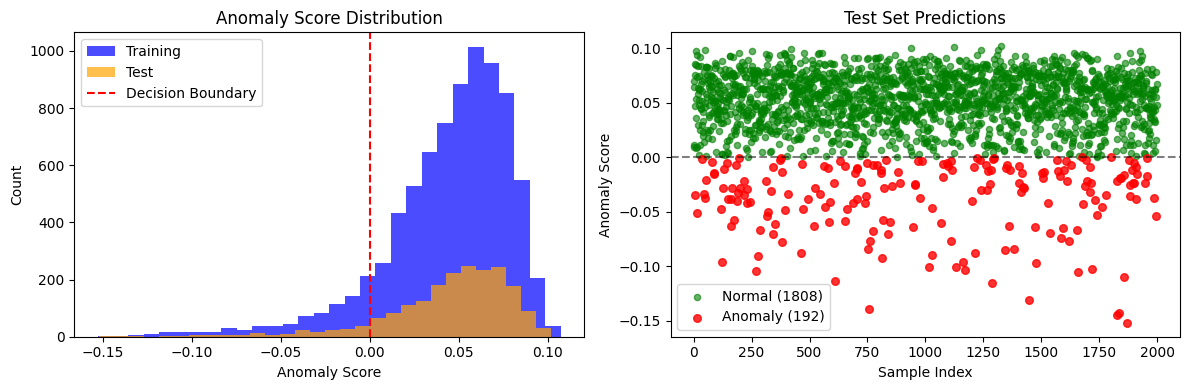

✓ Evaluation completed!

💼 Business Impact...
------------------------------
=== BUSINESS IMPACT ANALYSIS ===

📊 Detection Summary:
   Total cases analyzed: 2,000
   Anomalies detected: 192
   Anomaly rate: 9.6%

💰 Financial Impact:
   Total anomalous transaction value: $475,024.31
   Average anomaly value: $2,474.08
   Total normal transaction value: $1,431,805.79
   Anomaly % of total value: 24.9%


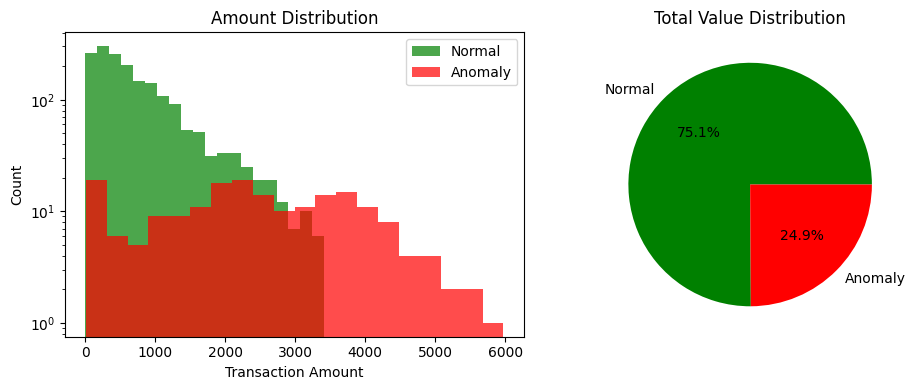


🎯 Recommendations:
   1. Investigate 192 flagged transactions
   2. Focus on high-value anomalies first
   3. Review billing processes for patterns
   4. Set up monitoring for future detection
   5. Validate findings with domain experts

📋 Summary Report:
   Total Cases: 2000
   Anomalies Detected: 192
   Anomaly Rate Pct: 9.6
   Model Type: IsolationForest
   Total Anomaly Value: 475024.31
   Avg Anomaly Value: 2474.08

✅ Flow completed successfully!


In [9]:
def run_flow():
    """Execute the complete flow"""
    print("🚀 Starting Revenue Leakage Detection Flow")
    print("=" * 50)
    
    steps = [
        ("📖 Reading Data", reading_data),
        ("🔍 Understanding Data", understanding),
        ("🧹 Preprocessing", preprocessing),
        ("⚙️ Feature Engineering", feature_engineering),
        ("🤖 Model Training", model_training_isolation_forest),
        ("📊 Evaluation", evaluate),
        ("💼 Business Impact", business_impact)
    ]
    
    for step_name, step_func in steps:
        print(f"\n{step_name}...")
        print("-" * 30)
        
        try:
            result = step_func()
            if result is None and step_func == reading_data:
                print("⚠️ Flow stopped due to data loading issues")
                return
        except Exception as e:
            print(f"❌ Error in {step_name}: {str(e)}")
            print("⚠️ Flow stopped")
            return
    
    print(f"\n✅ Flow completed successfully!")

# Run the flow
run_flow()